# A Basic Analysis of PBSB Artwork Data
An attempt to do some basic data analysis against my own datasets.

## Import libraries

In [3]:
!pip install wordcloud

from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import CSV file

In [5]:
# Define the URL of the dataset - in this case we are using a dataset that has been uploaded to OneDrive and shared
#file_path = "C:\\Users\\simon\\OneDrive\\Documents\\Artwork.csv"

# Load the dataset into a DataFrame
#df = pd.read_csv(file_path)

df = pd.read_csv("OneDrive/Documents/Artwork.csv", encoding='ISO-8859-1')

# Display the first few rows to ensure it loaded correctly
#print(df.head())

In [6]:
# Look at some basic statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerID            581 non-null    int64  
 1   PortraitID            581 non-null    int64  
 2   PriceListID           580 non-null    float64
 3   ServiceType           581 non-null    object 
 4   Title                 562 non-null    object 
 5   Medium                507 non-null    object 
 6   Grounds               506 non-null    object 
 7   Description           339 non-null    object 
 8   NumSubjects           579 non-null    float64
 9   PortraitSubjectNames  283 non-null    object 
 10  PortraitSubject       477 non-null    object 
 11  SaleType              580 non-null    object 
 12  BasePrice             581 non-null    object 
 13  PriceAdjustment       577 non-null    object 
 14  ThirdPartyCommission  581 non-null    object 
 15  CharitableDonations   5

In [7]:
# Basic size of the dataset, rows and columns
df.shape

(581, 35)

## Basic EDA
Some basic checks on the data.
### Check for duplicates
This should be a clean dataset, so we are not expecting any duplicates.

In [9]:
# Find duplicate rows and display count and head
duplicates = df[df.duplicated()]

print('There are ', duplicates.shape[0], ' duplicate rows')

There are  0  duplicate rows


### Missing values
Look for missing values in columns.  We know there are some by design, and some which have come about as a result of database redesign.

In [11]:
# Identify missing values for all columns
missing_values = df.isnull().sum()
print(missing_values)

CustomerID                0
PortraitID                0
PriceListID               1
ServiceType               0
Title                    19
Medium                   74
Grounds                  75
Description             242
NumSubjects               2
PortraitSubjectNames    298
PortraitSubject         104
SaleType                  1
BasePrice                 0
PriceAdjustment           4
ThirdPartyCommission      0
CharitableDonations       0
PhotosOnCDPrice           0
Photography              67
Travel                  204
FinalRetailPrice          0
DonatedCharity          570
CommssionPayableTo      527
SalesLocation           191
OrderDate                 2
CompletionDate          187
Size                     83
PortraitLandscape        74
Frame                     0
ActualTimeHrs             0
PromisedBy              298
Invoiced                  0
CommissionPaid            0
CommissionPaidDate      541
Framing                  87
Shipping                 94
dtype: int64


Missing OrderDate and SaleType indicate these were not records of sales, so we will drop them fom the dataframe.

In [13]:
# Let's drop the ones with no order date and no sale type
df = df.dropna(subset=['OrderDate', 'SaleType'])

## Basic Data Wrangling
### Clean Up FinalRetailPrice Column
A quick visual check of the dataframe shows that FinalRetailPrice has been loaded as a string value with a $ sign and a thousands separator. This needs to be converted into a clean numeric value for so that analysis can continue.

In [15]:
# Remove any trailing whitespace
df['FinalRetailPrice'] = df['FinalRetailPrice'].str.strip()

#Replace thousands separators
df['FinalRetailPrice'] = df['FinalRetailPrice'].str.replace(',', '')

# Replace '$' then convert to numeric
df['FinalRetailPrice'] = df['FinalRetailPrice'].str.replace('$', '').astype(float)


### Visualize Outliers
With that done, let's visualize the Visualize outliers in FinalRetaiPrice. To hide the actual price figures, I'm going to normalize the price data used throughout this analysis.

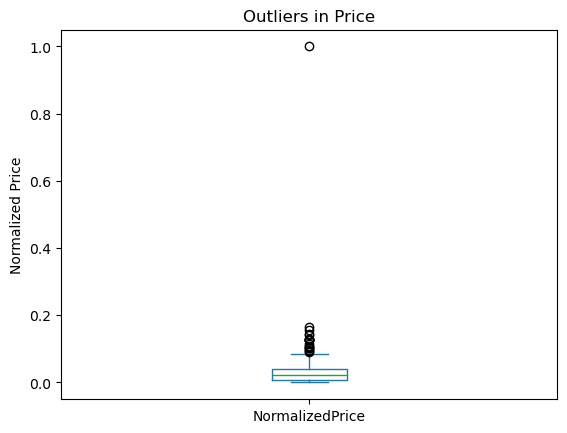

In [17]:
# Calc max and min painting prices
max_price = df['FinalRetailPrice'].max()
min_price = df['FinalRetailPrice'].min()

# Normalizereve nueusing max and min values
df['NormalizedPrice'] = (df['FinalRetailPrice'] - min_price) / (max_price - min_price)

# Visualize distribution of ConvertedCompYearly using a box plot
df['NormalizedPrice'].plot(kind='box')
plt.title('Outliers in Price')
plt.xlabel('')
plt.ylabel('Normalized Price')

# Save the plot as a PNG file
plt.savefig('outliers_box.png', format='png', dpi=300)

plt.show()


#### Identify outlier rows
Look at the basic statistics of the FinalRetailPrice column and identify the outlier records.

In [19]:
# Calculate mean, median and std deviation of ConvertedCompYearly
mean_val = df['NormalizedPrice'].mean()
median_val = df['NormalizedPrice'].median()
std_val = df['NormalizedPrice'].std()

print(f'\nThe mean value is: {mean_val:.2f}')
print(f'\nThe median value is: {median_val:.2f}')
print(f'\nThe standard deviation is: {std_val:.2f}')

# Identify outliers using 3 standard deviations above the mean
outlier_threshold = mean_val + (3 * std_val)
high_comp_outliers = df[df['NormalizedPrice'] > outlier_threshold]

print(f"\nNumber of high price outliers (>{outlier_threshold:.2f}): {len(high_comp_outliers)}")
print("\nHigh Price Outliers:")
print(high_comp_outliers[['CustomerID', 'NormalizedPrice', 'ServiceType']])


The mean value is: 0.03

The median value is: 0.02

The standard deviation is: 0.05

Number of high price outliers (>0.17): 1

High Price Outliers:
     CustomerID  NormalizedPrice ServiceType
110          38              1.0  Commission


#### Remove the outlier records
Use the IQR to define the outlier bounds. In this case we only want to remove the very largest values and none of the small ones.

In [21]:
# Recalculate quartiles and IQR
Q1 = df['NormalizedPrice'].quantile(0.25)
Q3 = df['NormalizedPrice'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds - these are broader than usual
lower_bound = Q1 - 20 * IQR
upper_bound = Q3 + 20 * IQR

# Remove outliers from dataframe
df = df[(df['NormalizedPrice'] <= upper_bound)]

### Re-visualize Normalized Price Data
With the outlier(s) removed, recalculate the normalized prices so that they are meaningful, then show the box plot

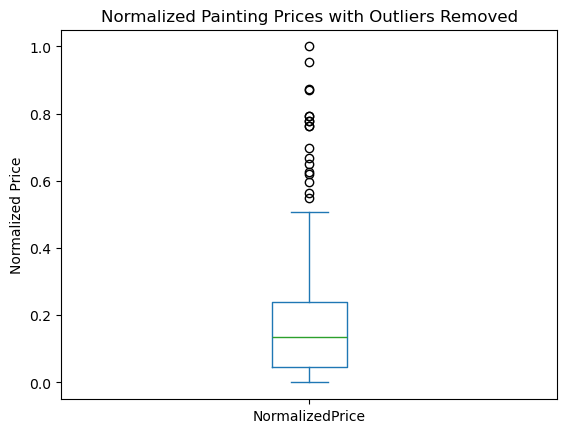

In [23]:
# Recalculate max and min painting prices
max_price = df['FinalRetailPrice'].max()
min_price = df['FinalRetailPrice'].min()

# Normalizereve nueusing max and min values
df['NormalizedPrice'] = (df['FinalRetailPrice'] - min_price) / (max_price - min_price)

# Visualize distribution of FinalRetailPrice with outliers removed using a box plot
df['NormalizedPrice'].plot(kind='box')
plt.title('Normalized Painting Prices with Outliers Removed')
plt.xlabel('')
plt.ylabel('Normalized Price')

# Save the plot as a PNG file
plt.savefig('no_outliers_box.png', format='png', dpi=300)

plt.show()

### Distribution of Prices
Look at the way in which number of sales is related to the price of the work.

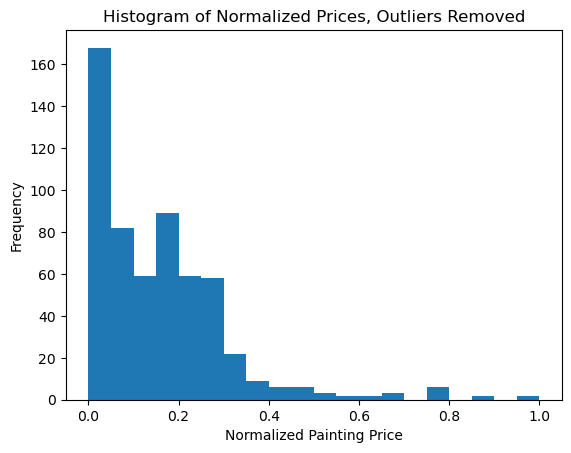

In [25]:
# Histogram of data with outliers removed just to check it
plt.hist(x=df['NormalizedPrice'], bins=20)

plt.ylabel('Frequency')
plt.xlabel('Normalized Painting Price')
plt.title('Histogram of Normalized Prices, Outliers Removed')

# Save the plot as a PNG file
plt.savefig('price_hist.png', format='png', dpi=300)

plt.show()

## Basic Visualizations
Let's look at how the artwork data is distributed, so we can start to understand more about my paintings and how the painting business has changed over time.
### What Kind of Painting Do I Create
This is a broad look at how my painting work is split between commissioned painting and retail paintings that I do of my own free will, so to speak.

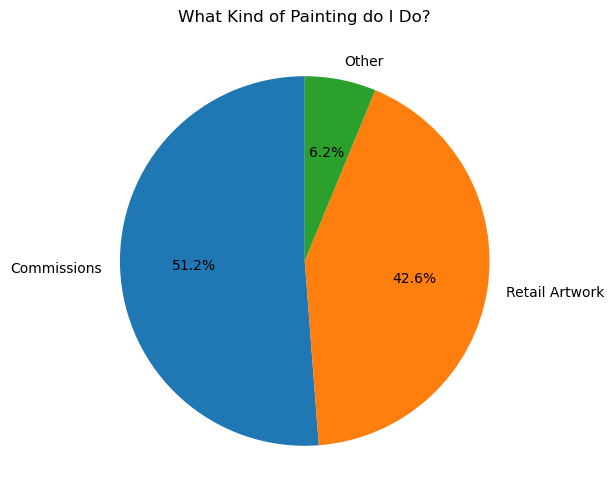

In [27]:
# Convert the ServiceType attribute so that the main categories are renamed
mapping = {'Commission': 'Commissions', 'Artwork sale': 'Retail Artwork'}

# Apply the mapping and use the .get method to map everything else to 'Other'
df['ServiceType'] = df['ServiceType'].apply(lambda x: mapping.get(x, 'Other'))
           
# Get the value counts and convert to DataFrame
df_sorted = df['ServiceType'].value_counts().reset_index()

# Rename the columns
df_sorted.columns = ['ServiceType', 'count']

# Sort the DataFrame by count in descending order
df_sorted = df_sorted.sort_values(by='count', ascending=False)

# Plot as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(data=df_sorted, x='count', labels=df_sorted['ServiceType'], autopct='%1.1f%%', startangle=90)

# Display the plot
plt.title('What Kind of Painting do I Do?')
plt.ylabel('')  # Hide the y-axis label

# Save the plot as a PNG file
plt.savefig('types.png', format='png', dpi=300)

plt.show()

The 'Other' category cover a bunch of miscellaneous things like charitable donations, licensing, notecards and painting restoration.
### How Has the Makeup of my Business Changed Over Time?
Obviously, the business has not been static and things have changed as my circumstance, location and interests have changed.

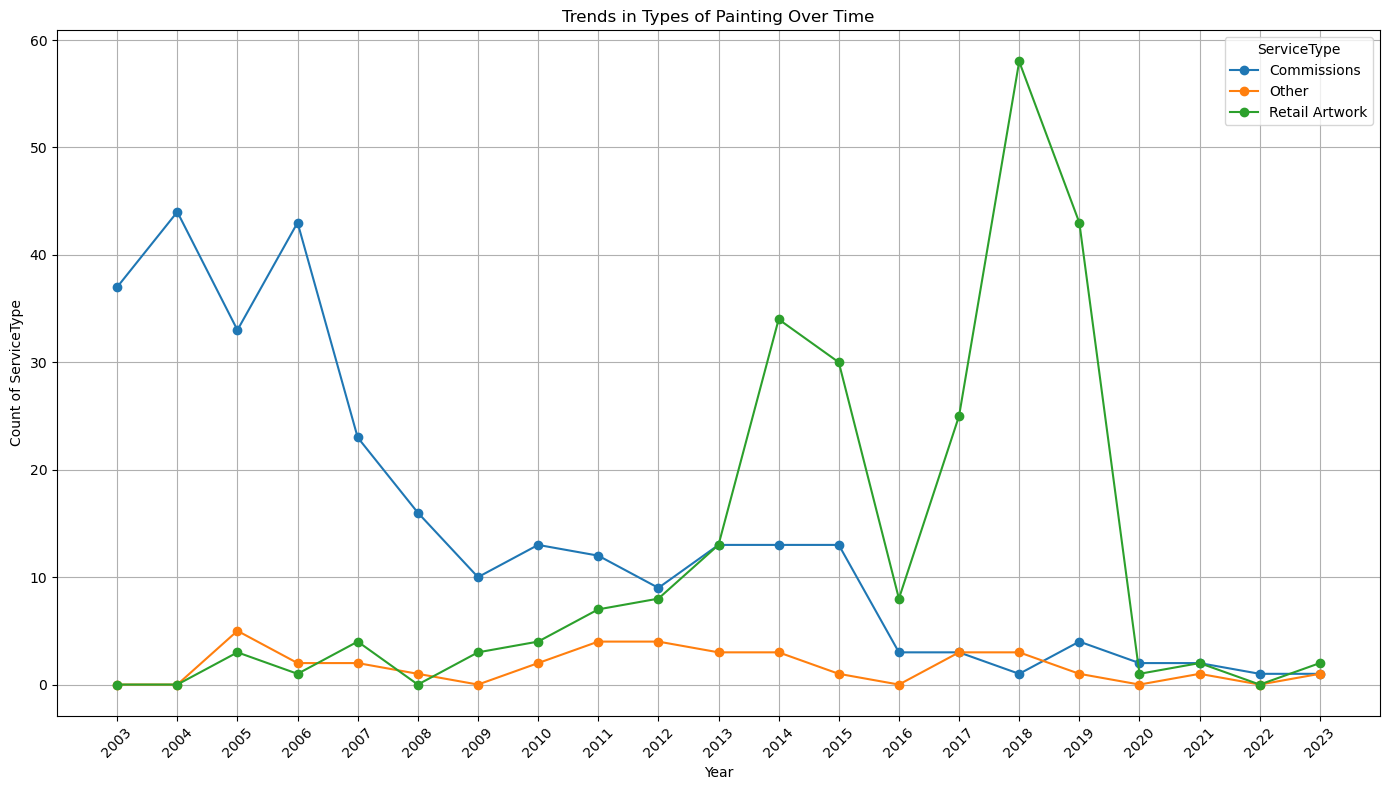

In [29]:
# Use a line chart to show how business has changed over time
fig, ax = plt.subplots(figsize=(14, 8))

# Assuming 'OrderDate' is in datetime format
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Extract the year from 'OrderDate'
df['Year'] = df['OrderDate'].dt.year

# Group by 'Year' and 'ServiceType' and count occurrences
df_grouped = df.groupby(['Year', 'ServiceType']).size().unstack(fill_value=0)

# Plot each ServiceType as a separate line
for service_type in df_grouped.columns:
    ax.plot(df_grouped.index, df_grouped[service_type], marker='o', label=service_type)

# Customize the x-axis ticks to show the years
ax.set_xticks(df_grouped.index)
ax.set_xticklabels(df_grouped.index, rotation=45)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Count of ServiceType')
plt.title('Trends in Types of Painting Over Time')
plt.legend(title='ServiceType')
plt.grid(True)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('trends.png', format='png', dpi=300)

# Show the plot
plt.show()


### What Kinds of Commissioned Portraits Have I Created?
Break out of PortraitSubject with SaleType = 'Commission'

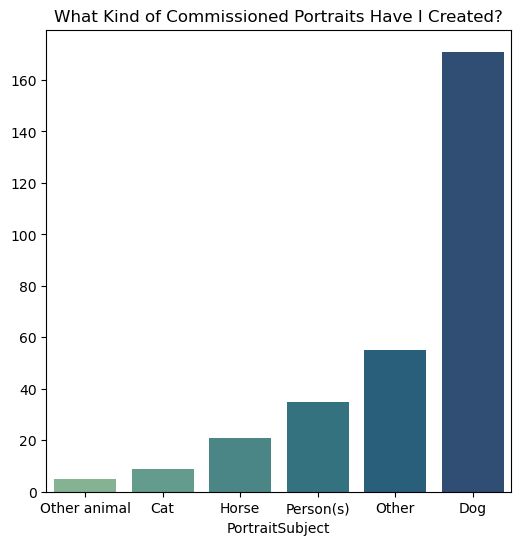

In [74]:
# First get ServiceTypes that are just for portraits
df_portrait = df[df['ServiceType'] == 'Commissions']

# Convert the PortraitType attribute so that the minor categories are renamed
portrait_mapping = {'Dog': 'Dog',
                    'Horse': 'Horse',
                    'Person': 'Person(s)',
                    'People': 'Person(s)',
                    'Chicken': 'Other animal',
                    'Piglet': 'Other animal',
                    'Cat': 'Cat',
                    'Animal': 'Other animal',
                    'Bird' : 'Other animal',
                    'Birds': 'Other animal'
                   }

# Apply the mapping and use the .get method to map everything else to 'Other'
df_portrait.loc[:,'PortraitSubject'] = df_portrait['PortraitSubject'].apply(lambda x: portrait_mapping.get(x, 'Other'))

# Group by 'PortraitSubject' and count occurrences
df_grouped = df_portrait.groupby(['PortraitSubject']).size().reset_index(name='count')

# Sort the table
df_grouped = df_grouped.sort_values(by=['count'], ascending=True)

# Plot as a pie chart
plt.figure(figsize=(6, 6))
#plt.barh(df_grouped['PortraitSubject'], df_grouped['count'])
sns.barplot(x='PortraitSubject', y='count', data=df_grouped, palette='crest', hue='PortraitSubject')

# Display the plot
plt.title('What Kind of Commissioned Portraits Have I Created?')
plt.ylabel('')  # Hide the y-axis label

# Save the plot as a PNG file
plt.savefig('portraits.png', format='png', dpi=300)

plt.show()


### What are the Names of the Dogs in my Commissioned Paintings?
This is just an excuse to ceate a wordcloud, but the results are pretty.

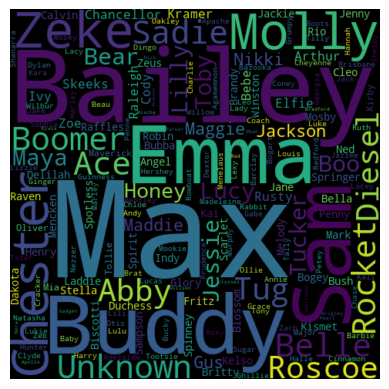

In [33]:
# First get commissioned portraits that are just of dogs/horses/cats
df_portrait_filtered = df[df['PortraitSubject'] == 'Dog']

#First, drop any records that have nulls in PortraitSubjectName
df_portrait_filtered = df_portrait_filtered.dropna(subset=['PortraitSubjectNames'])

#Concatenate all the values in the PortraitSubjectNames column into a single string
text = ' '.join(df_portrait_filtered['PortraitSubjectNames'].astype(str))

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480,
            margin=0).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

# Save the plot as a PNG file
plt.savefig('wordcloud_dog.png', format='png', dpi=300)

plt.show()

### What are the Names of the Horses in my Commissioned Paintings?
Same thing, but for horses.

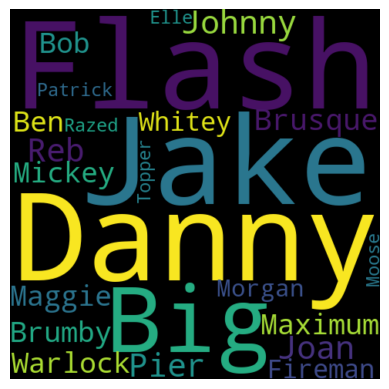

In [35]:
# First get commissioned portraits that are just of dogs/horses/cats
df_portrait_filtered = df[df['PortraitSubject'] == 'Horse']

#First, drop any records that have nulls in PortraitSubjectName
df_portrait_filtered = df_portrait_filtered.dropna(subset=['PortraitSubjectNames'])

#Concatenate all the values in the PortraitSubjectNames column into a single string
text = ' '.join(df_portrait_filtered['PortraitSubjectNames'].astype(str))

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480,
            margin=0).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

# Save the plot as a PNG file
plt.savefig('wordcloud_horse.png', format='png', dpi=300)

plt.show()

### How Did Revenues Change Over Time?
Things change in the art world and external events can have an effect on business. These are my normalized revenues by year.

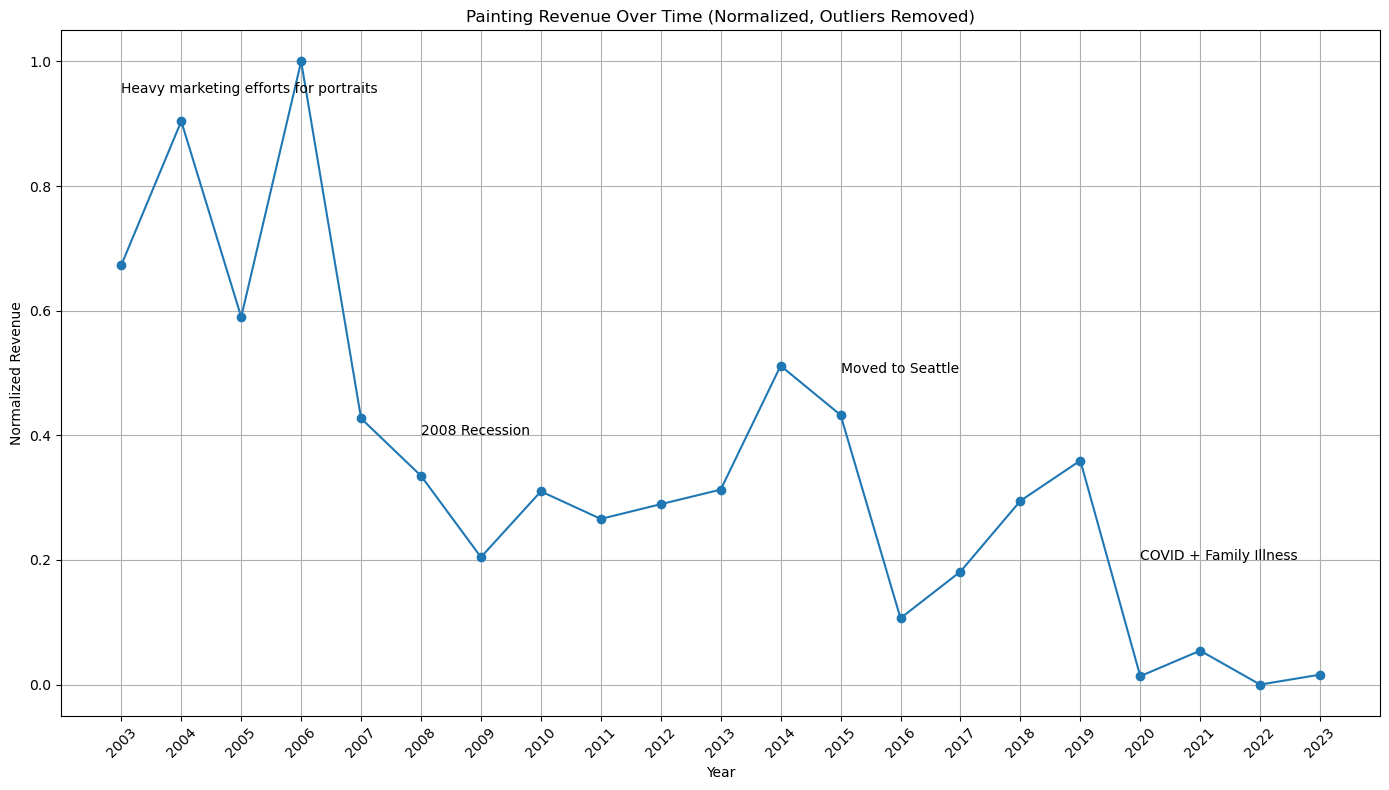

In [37]:
# Group by 'Year' and sum 'FinalRetailPrice'
df_revenue_grouped = df.groupby(['Year'])['FinalRetailPrice'].sum().reset_index(name='total_revenue')

# Calc max and min annual revenues
max_revenue = df_revenue_grouped['total_revenue'].max()
min_revenue = df_revenue_grouped['total_revenue'].min()

# Normalize revenue using max and min values
df_revenue_grouped['normalized_revenue'] = (df_revenue_grouped['total_revenue'] - min_revenue) / (max_revenue - min_revenue)

# Create the figure and axis for the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Basic Line Plot
ax.plot(df_revenue_grouped['Year'], df_revenue_grouped['normalized_revenue'], marker='o', label=service_type)

# Annotate a specific point
plt.annotate('Heavy marketing efforts for portraits', xy=(2003, 0.95), xytext=(2003, 0.95), size=10)
plt.annotate('2008 Recession', xy=(2008, 0.4), xytext=(2008, 0.4), size=10)
plt.annotate('Moved to Seattle', xy=(2015, 0.5), xytext=(2015, 0.5), size=10)
plt.annotate('COVID + Family Illness', xy=(2020, 0.2), xytext=(2020, 0.2), size=10)

# Customize the x-axis ticks to show the years
ax.set_xticks(df_revenue_grouped['Year'])
ax.set_xticklabels(df_revenue_grouped['Year'], rotation=45)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Normalized Revenue')
plt.title('Painting Revenue Over Time (Normalized, Outliers Removed)')
plt.grid(True)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('revenues.png', format='png', dpi=300)

# Show the plot
plt.show()